# Data Analysis
This file contains step-by-step information on how I conducted the analysis. Comments are included in each step to provide more clarity. 


## Data Processing
This section involves preparing the data for analysis

### Importing necessary packages

In [7]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

### Loading the data

In [8]:
#Load Weekly Stock Data
stock_prices = pd.read_csv('20comp.csv', index_col = 'Date', parse_dates=True)
#Load Market Data
market_index = pd.read_csv('SPY.csv', index_col = 'Date', parse_dates=True)
#Load 3-Mo Rf
risk_free_rate = pd.read_csv('TB3MS.csv', index_col= 'Date', parse_dates=True)

### Modifying the Risk Free Rate Data Set
The data I used for the risk-free rate is the ["3-Month Treasury Bill Secondary Market Rate, Discount Basis (TB3MS)"](https://fred.stlouisfed.org/series/TB3MS#0) from the Federal Reserve Bank of St. Louis (FRED)

This data is available in a monthly frequency, however I am working with weekly stock and market returns. 

Therefore, I must first expand the data set to include time periods that match that of the return data and forward fill missing values with the yield from the beginning of each month to the end of the month.

From there, I will convert these annualized rates and convert them to weekly rates

In [9]:
#Set start date for data extension
start_date = risk_free_rate.index.min()
#Set end date for data extension
end_date = risk_free_rate.index.max()
#Create new rows in data
weekly_dates = pd.date_range(start=start_date, end=end_date, freq ='7D')
#Reindex
risk_free_rate_w = risk_free_rate.reindex(weekly_dates)
#Forward fill N/As
risk_free_rate_w.fillna(method = 'ffill', inplace = True)
#Convert to weekly rate
risk_free_rate_w['Weekly_Risk_Free_Rate'] = (1 + risk_free_rate_w['TB3MS'] / 100)** (1/52)-1

C:\Users\Andres\AppData\Local\Temp\ipykernel_24892\1072953067.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  risk_free_rate_w.fillna(method = 'ffill', inplace = True)


### Calculating Weekly Returns and Excess Returns
In this section I begin by merging all the data sets together. 

I proceed by calculating the weekly returns for both the stocks and the market index.

Thereafter, the risk free rate is subtracted from the returns to derive excess returns

In [10]:
#Merge Data Sets
data = stock_prices.join(market_index, how = 'inner').join(risk_free_rate_w, how = 'inner')
#Calculate weekly returns
stock_returns = data[stock_prices.columns].pct_change().dropna()
market_returns = data['SPY'].pct_change().dropna()
#Align rf rate with returns data
weekly_rf_rate = risk_free_rate_w['Weekly_Risk_Free_Rate'].reindex(stock_returns.index)
#Excess Stock Returns
excess_stock_returns = stock_returns.sub(weekly_rf_rate.values, axis = 0)
#Excess Market Returns 
excess_market_returns = market_returns - weekly_rf_rate.values

# Regression Analysis
In this section we run the regression of excess market returns on excess stock returns for each company and display the results

In [11]:
#Create list to store results
results = []
#Regression Loop 
for company in stock_returns.columns:
    X=sm.add_constant(excess_market_returns)
    y = excess_stock_returns[company]
    model = sm.OLS(y,X).fit()
    results.append({
        'Company': company,
        'Alpha': model.params['const'],
        'Beta': model.params['SPY'],
        'R-Squared': model.rsquared,
        'P-Value (Alpha)': model.pvalues['const'],
        'P-Value (Beta)': model.pvalues['SPY']
    })
#Store results in dataframe
results_df = pd.DataFrame(results)
#Show Results
print(results_df)

   Company     Alpha      Beta  R-Squared  P-Value (Alpha)  P-Value (Beta)
0     MSFT  0.002604  1.115923   0.517416         0.008381    5.227865e-87
1     APPL  0.002204  1.186375   0.450803         0.065879    6.694534e-72
2     NVDA  0.007909  1.775526   0.354200         0.000332    5.915682e-53
3     AMZN  0.001918  1.349639   0.399808         0.204604    1.605056e-61
4     META  0.001894  1.388003   0.319677         0.306170    7.358461e-47
5     GOOG  0.001176  1.154468   0.450506         0.312884    7.745019e-72
6    BRK-B  0.000604  0.776618   0.503332         0.391367    1.198976e-83
7     AVGO  0.004326  1.295493   0.371033         0.005163    4.811605e-56
8      LLY  0.004760  0.452855   0.082519         0.000601    1.064800e-11
9      JPM  0.000709  1.057036   0.428483         0.525209    3.034530e-67
10    TSLA  0.004226  1.852410   0.222511         0.182005    3.248673e-31
11     XOM -0.000458  0.853515   0.257744         0.729100    1.181612e-36
12       V  0.000985  1.0

## Regression Results 

### Companies Whose Excess Returns Violate the CAPM 
- Microsoft (MSFT)
- NVIDIA Corp (NVDA)
- Broadcom Inc (AVGO)
- Eli Lilly & Co (LLY)
- Costco Wholesale Corp (COST)

These 5 companies have an alpha coefficient that is statistically different from 0. Under the CAPM, the alpha coefficient should be equal to 0 indicating the abscense of abnormal returns. Thus, These 5 companies violate the CAPM

### Companies Whose Excess Returns Support the CAPM
- Apple (APPL)
- Amazon.com Inc (AMZN)
- Meta Platforms Inc. (META)
- Alphabet Inc (GOOG)
- Berkshire Hathaway (BRK-B)
- JPMorgan Chase & Co (JPM)
- Exxon Mobil Corp (XOM)
- Tesla Inc (TSLA)
- Visa Inc (V)
- Proctor & Gamble Co (PG)
- MasterCard Inc (MA)
- Johnson & Johnson (JNJ)
- Home Depot Inc (HD)
- Merck & Co Inc (MRK)
- Abbvie Inc (ABBV)

The remaining 15 companies have an alpha coefficient that is not statistically significantly different from 0. Therefore, their returns are explained by the market and the CAPM appears to hold for this sample of companies.

The beta values for the companies in the dataset indicate varying levels of market sensitivity. High beta companies like NVIDIA (NVDA) and Tesla (TSLA) have higher beta values, suggesting they are more sensitive to market movements and exhibit greater volatility. Low beta companies such as Berkshire Hathaway (BRK-B) and Johnson & Johnson (JNJ) reflect more stable returns with less sensitivity to market fluctuations. 

# Data Visualization
The following sections include multiple data visualization techniques to provide a better understanding of the results of the analysis.

### Excess Returns Scatter Plot with Regression Lines (All Companies)
This graph provides a comprehensive visualization of the CAPM regression analysis for all the companies in my dataset. Each company is represented by a different color, and the scatter points show the excess returns of the stocks against the excess market returns. The regresion lines indicate the relationship between the market and each stock's excess returns

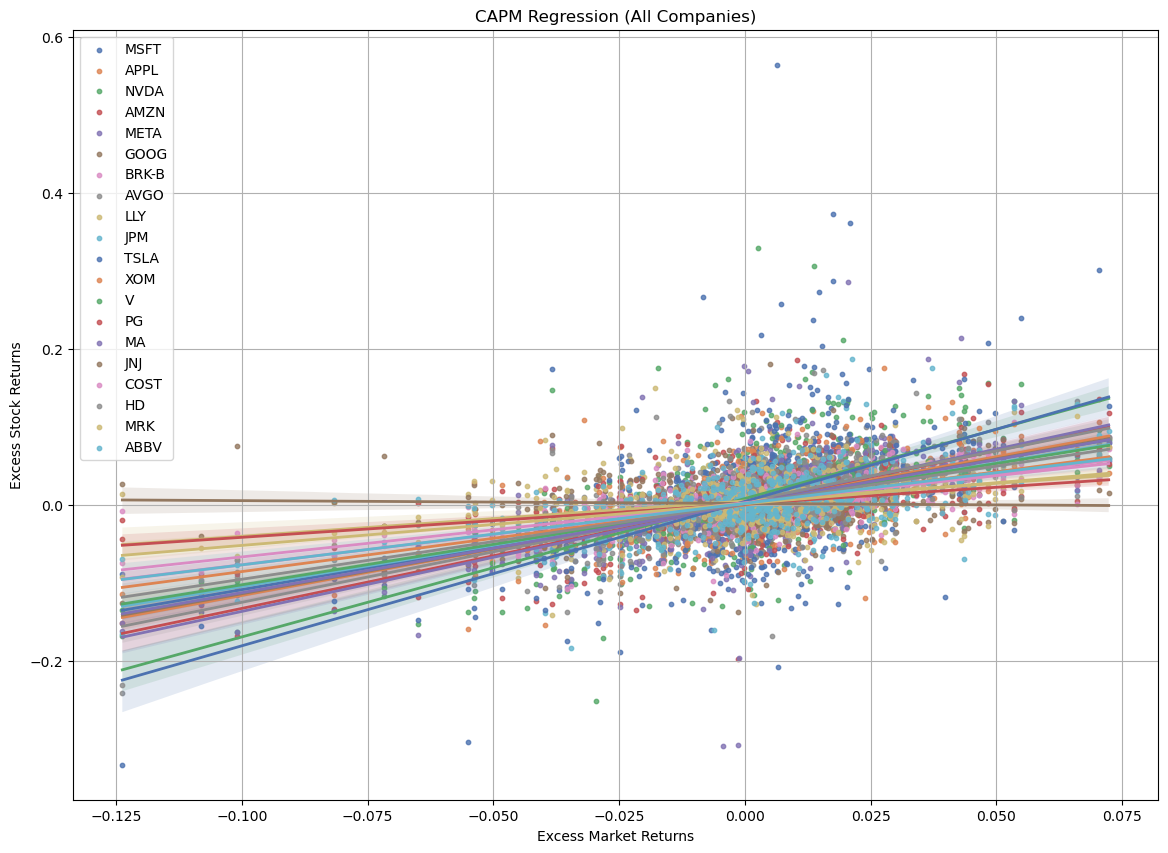

In [12]:
#Set color palette
palette = sns.color_palette('deep', n_colors=len(stock_returns.columns))
#Figure Size
plt.figure(figsize=(14,10))
#Loop for each company
for i, company in enumerate(stock_returns.columns):
    sns.regplot(x=excess_market_returns, y=excess_stock_returns[company],
                label=company, color=palette[i], scatter_kws={'s':10}, line_kws={'linewidth':2})
#Plot formatting
plt.xlabel('Excess Market Returns')
plt.ylabel('Excess Stock Returns')
plt.title('CAPM Regression (All Companies)')
plt.legend()
plt.grid(True)
plt.show()

### Excess Returns Scattered Plots with Regression Lines (Individual Companies) 
This figure provides a more nuanced visualization of the CAPM regression analysis. It includes a graph for each company in the dataset. As before the scatter points show the excess returns of the stocks against the excess returns of the market and the regression lines indicate the relationship between the market and each stock's excess returns. 

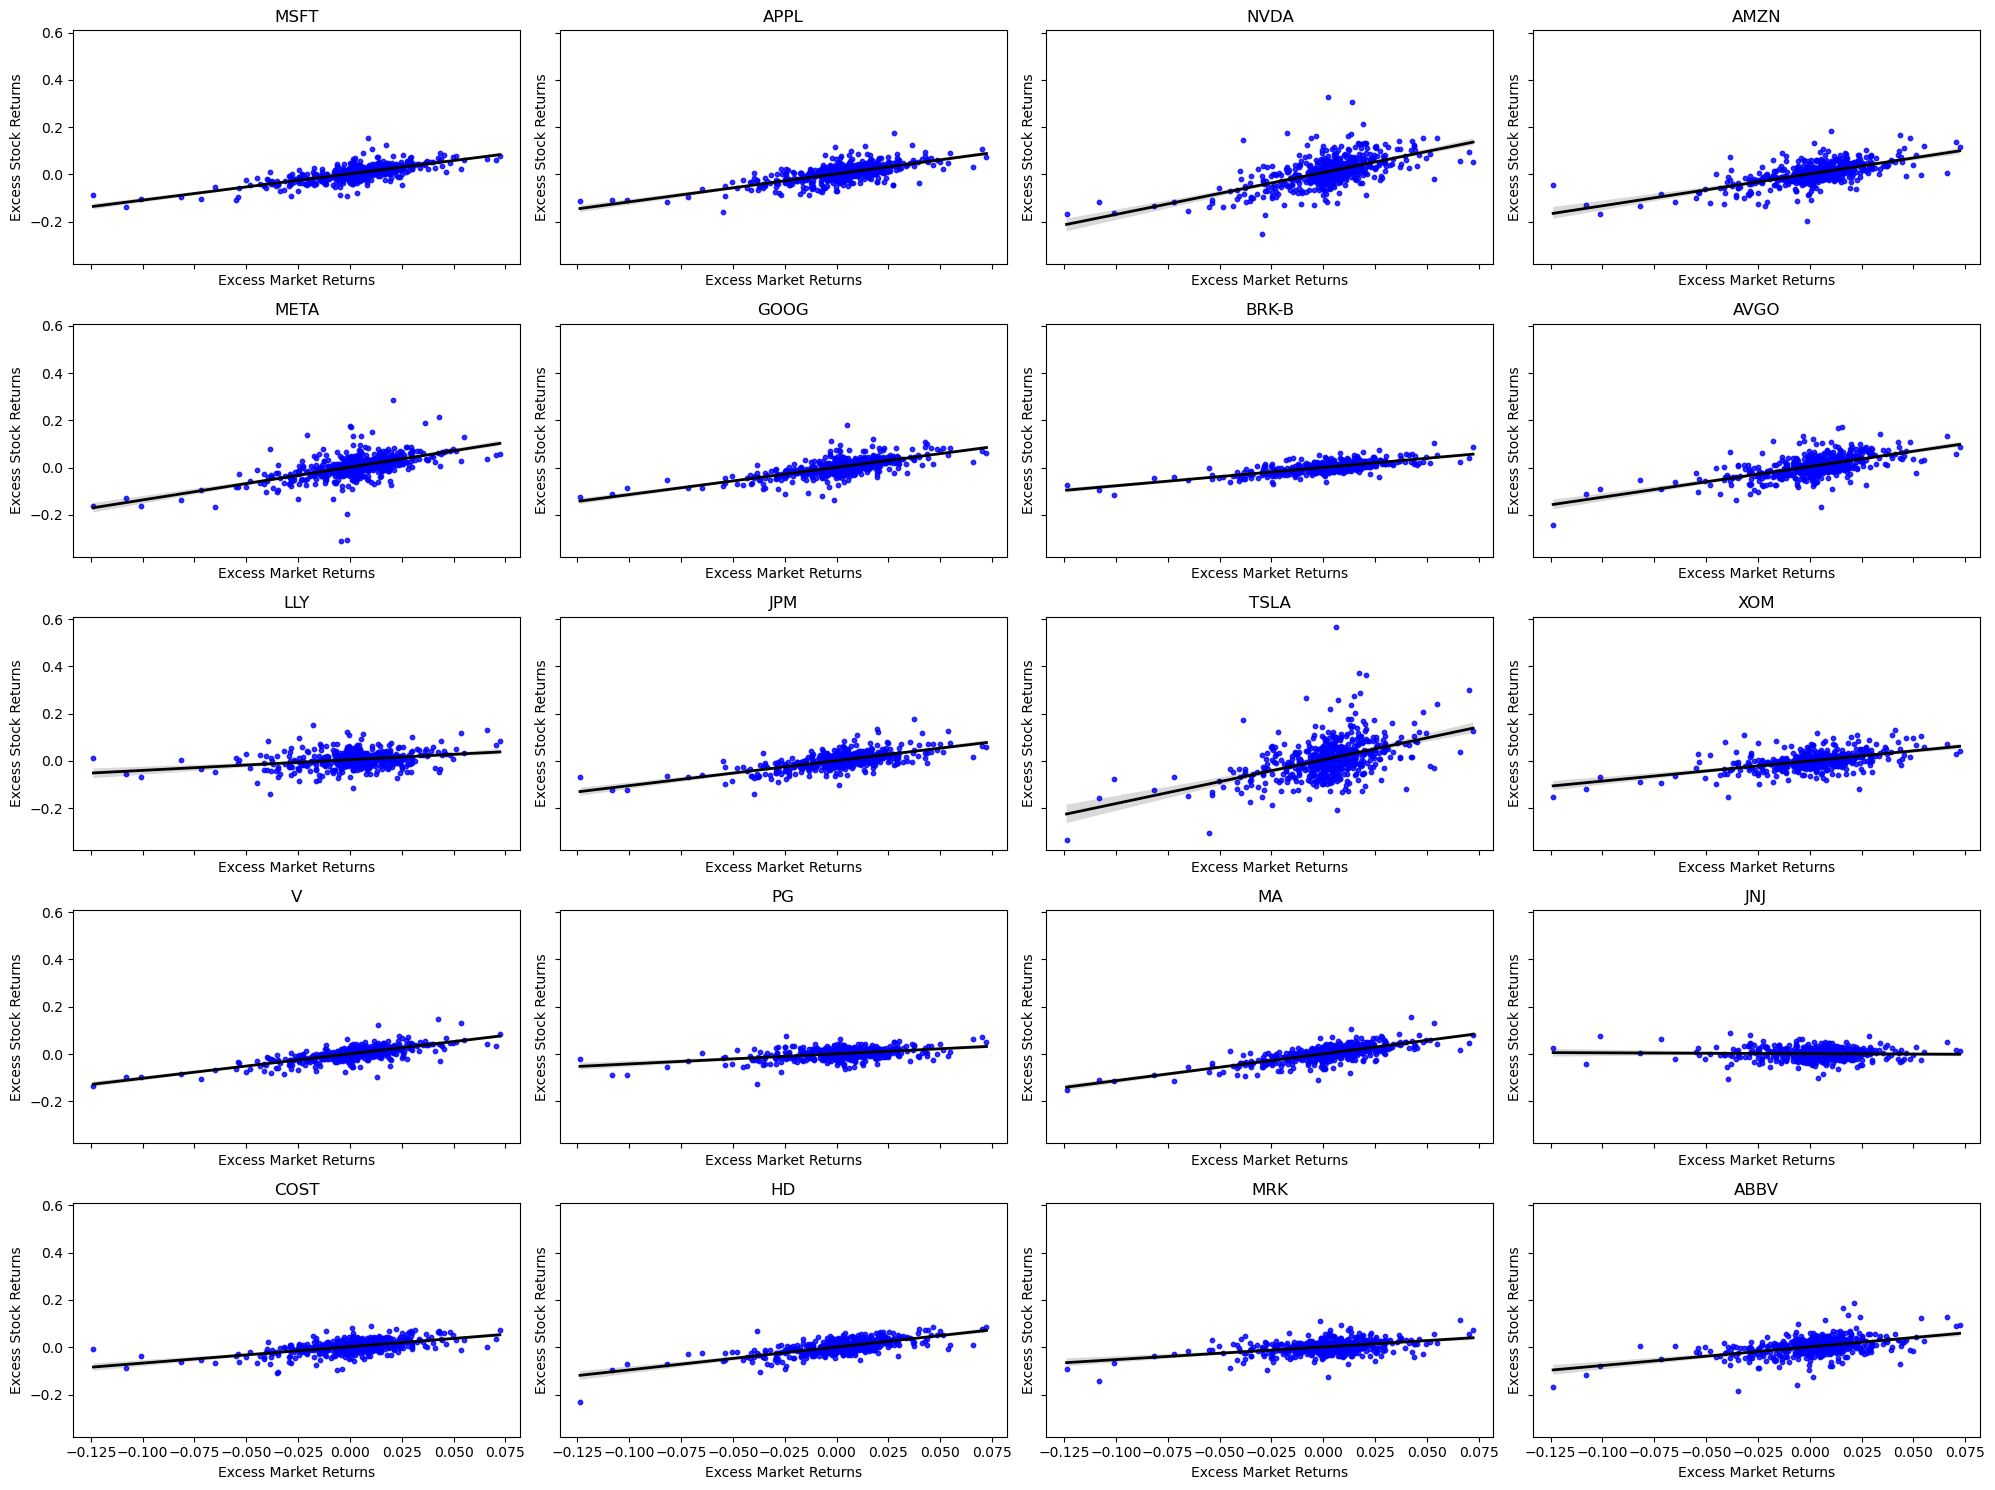

In [13]:
#Number of companies
num_companies = len(stock_returns.columns)
#Create Grid Size
cols = 4 
rows = (num_companies + cols - 1) // cols
#Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 15), sharex=True, sharey=True)
#Flatten axes
axes = axes.flatten()
#Plot each company's scatter plot with regression line in a separate subplot
for i, company in enumerate(stock_returns.columns):
    sns.regplot(x=excess_market_returns, y=excess_stock_returns[company], ax=axes[i],
                scatter_kws={'color': 'blue', 's': 10}, line_kws={'color': 'black', 'linewidth': 2})
    axes[i].set_title(company)
    axes[i].set_xlabel('Excess Market Returns')
    axes[i].set_ylabel('Excess Stock Returns')
plt.tight_layout()
plt.show()

### Histogram of Alpha Distribution
This histogram vizualizes the distribution of the alpha values for all the companies in my dataset. Alpha represents the intercept in the CAPM regression, which measures the stocks abnormal returns not explained by the market. A positive alpha indicated that the stock has performed better than expected based on the market's performance, while a negative apha indicates underperformance. 

The histogram is centered near zero and skewed leftwards. This shows that most of the alpha values are clustered around 0.002. Suggesting that the majority of the stocks have small positive alphas, indicating slight outperformance relative to the CAPM prediction. However, they are not not significantly different than zero.  

c:\Users\Andres\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<function matplotlib.pyplot.show(close=None, block=None)>

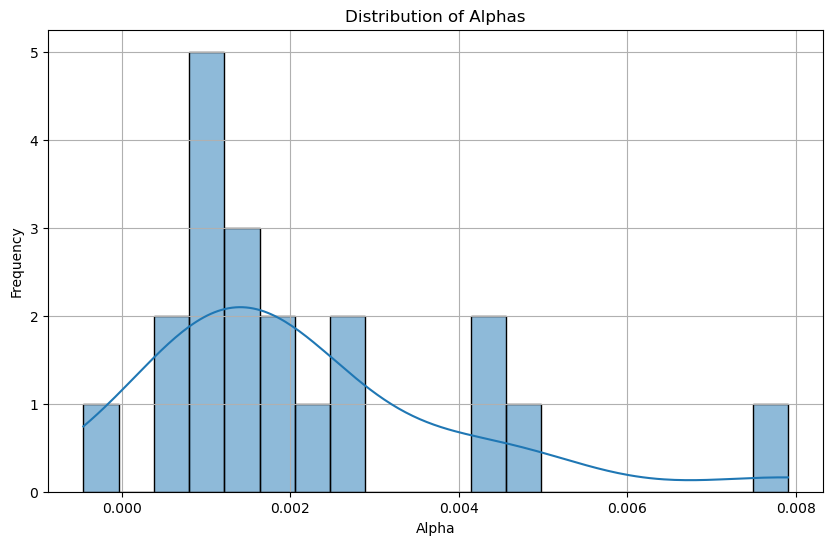

In [56]:
#Histogram of Alpha Distribution
plt.figure(figsize=(10,6))
sns.histplot(results_df['Alpha'], kde=True, bins=20)
plt.xlabel('Alpha')
plt.ylabel('Frequency')
plt.title('Distribution of Alphas')
plt.grid(True)
plt.show

### Stock Returns vs. Market Returns Time Series
The subplots in this figure display the time series of weekly returns for each company alongside the market returns. Each subplot contains two lines: one representing the weekly returns of the specific stock and the other representing the weekly returns of the market. 

Most companies' stock returns generally follow the market returns, indicating a level of correlation with the market. NVIDIA (NVDA) and Tesla (TSLA) exhibit higher volatility compared to other companies, with more significant spikes and troughs in their weekly returns. This suggests that these stocks are more sensitive to markt movements and potentially more influenced by company-specific events. Berkshire Hathaway (BRK-B) and Johnson & Johnson (JNJ) show relatively stable returns with less volatility, indicating that these stocks are less sensitive to market fluctuations. 

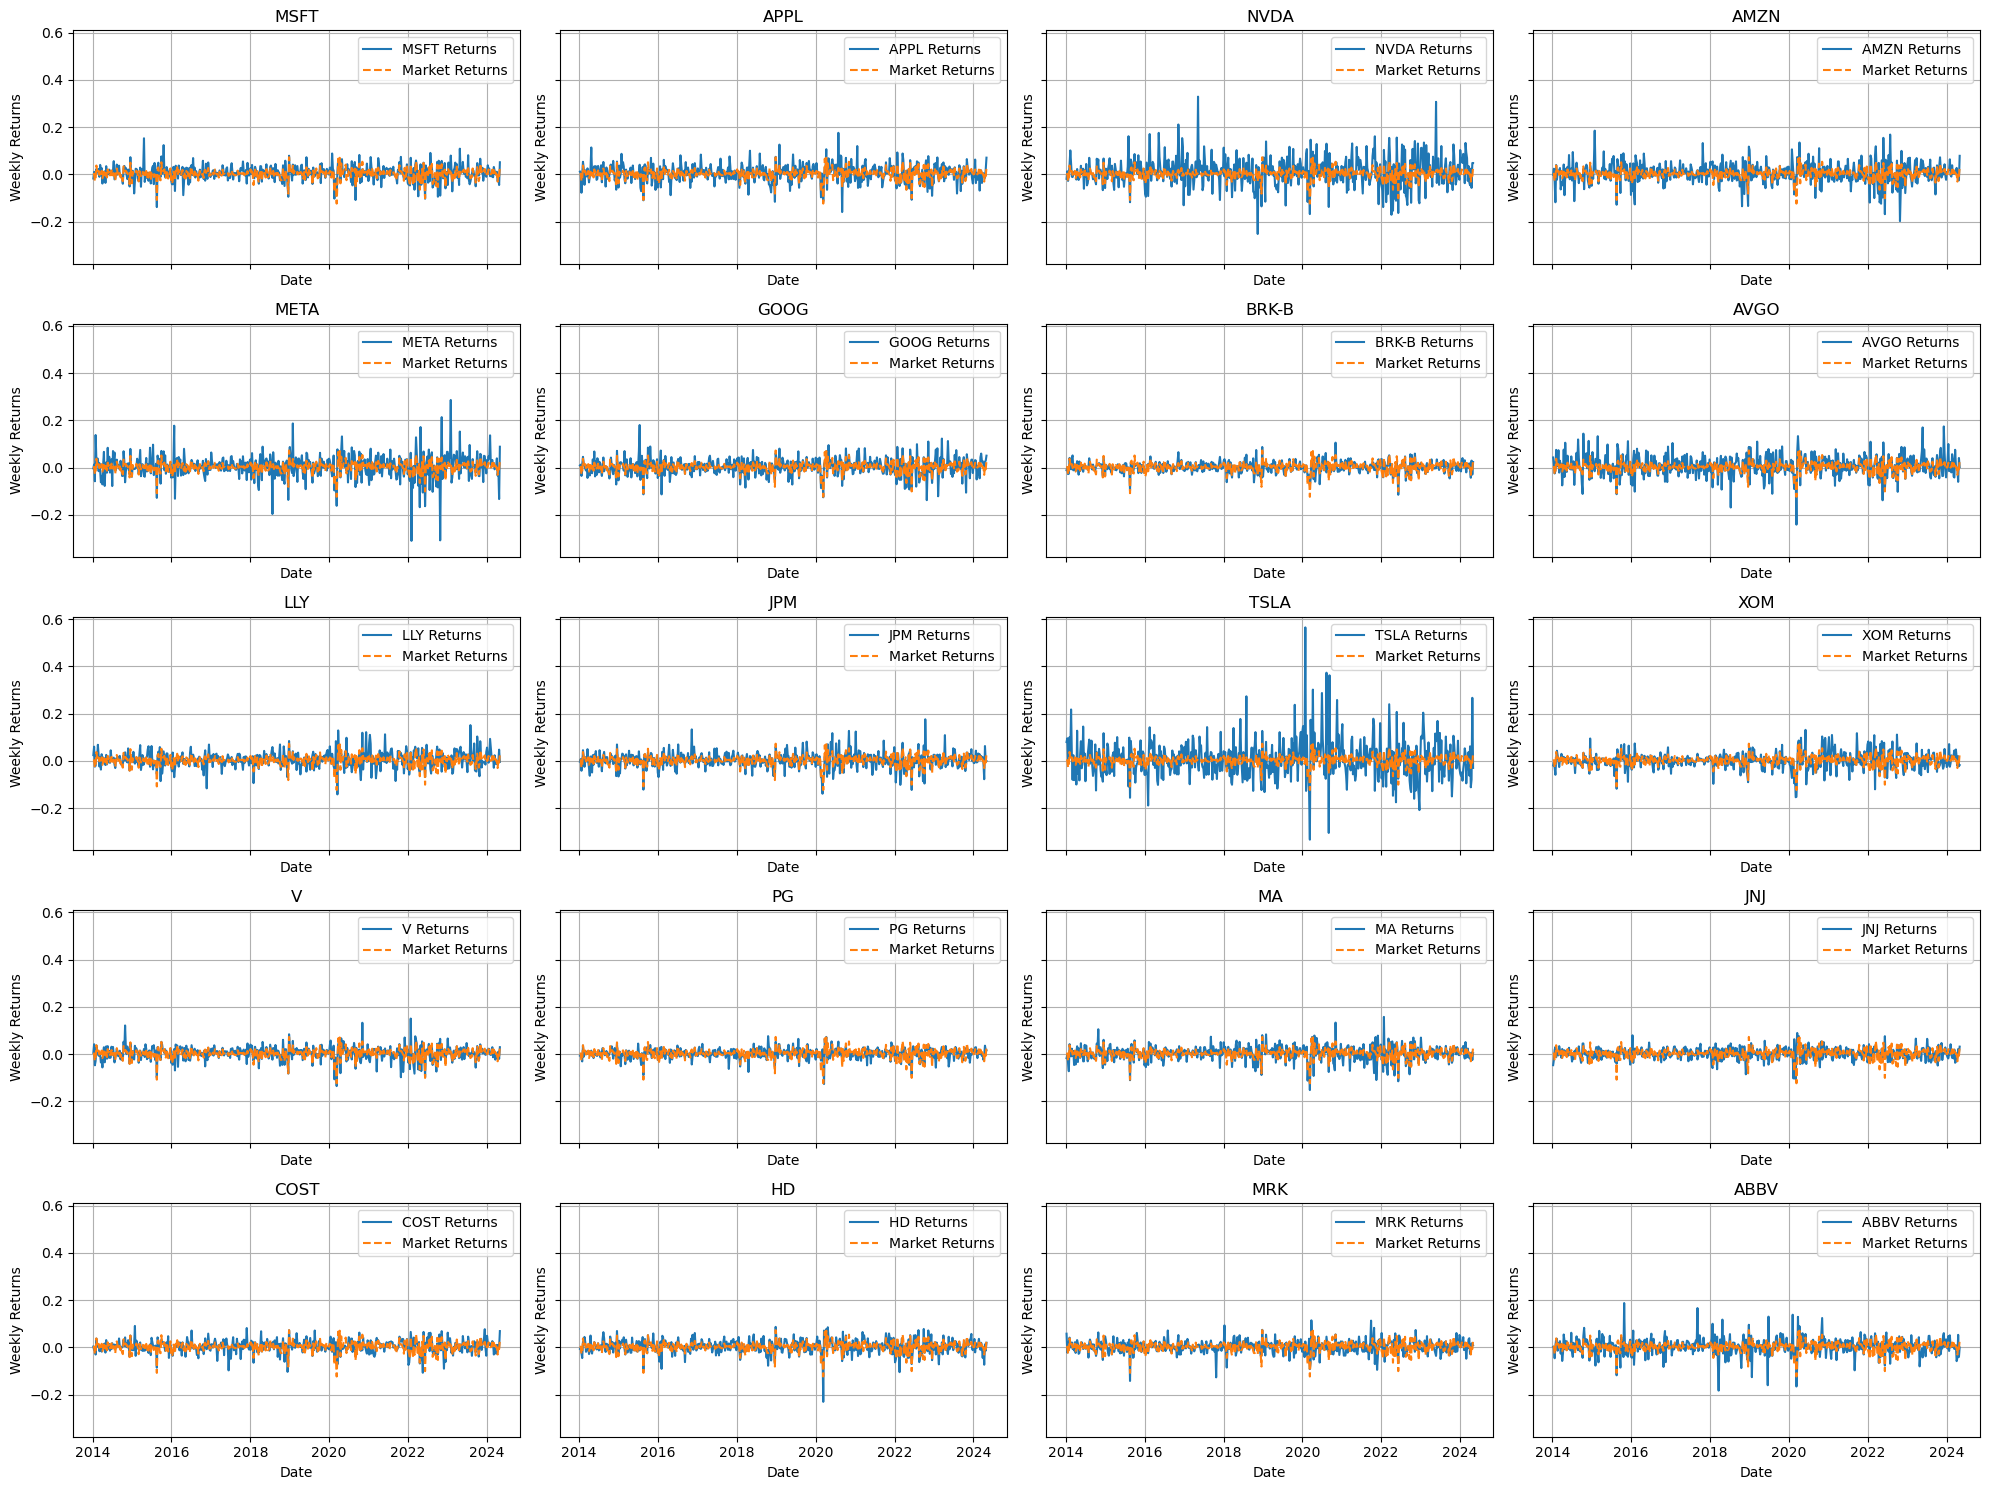

In [60]:
#Stock Returns vs. Market Returns Time Series
#Number of Companies
num_companies = len(stock_returns.columns)
#Determine Grid Size
cols = 4
rows = (num_companies + cols-1)//cols
#Create Subplots
fig,axes = plt.subplots(rows, cols, figsize=(20,15), sharex=True, sharey =True)
#Flatten Axes
axes =axes.flatten()
#Plot each company's time series
for i, company in enumerate(stock_returns.columns):
    axes[i].plot(stock_returns.index, stock_returns[company], label=f'{company} Returns')
    axes[i].plot(market_returns.index, market_returns, label='Market Returns', linestyle = '--')
    axes[i].set_title(f'{company}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Weekly Returns')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()


# Conclusion
The analysis of the Capital Asset Pricing Model (CAPM) applied to the weekly returns of 20 major firms from the S&P 500 index reveals several important insights. The majority of stocks exhibit small positive alphas, indicating slight deviations from the CAPM predictions, with a few stocks showing statistically significant positive alphas, such as Microsoft (MSFT), NVIDI (NVDA), Broadcom (AVGO), Eli Lilly (LLY), and Costco (COST). These significant alphas suggest that these stocks have consistently outperformed market expectations, highlightng instances where CAPM may not fully capture stock performance. The regressions analysis reveals varying beta values across the stocks, reflecting different sensitivities to market movements. Higher betas, observed in stocks like NVIDIA and Tesla (TSLA), indicate greater volatility, while lower beta stocks like Berkshire Hathaway (BRK-B) and Johnson & Johnson (JNJ) suggest more stable returns. Overall, while the CAPM provides a valuable framework for understanding the relationship between risk and return, the presence of significant alphas and varying betas, as well as the observed divergences and unique stock-specific events, suggest that the model does not full caputure all complexities of real-world stock returns. Thus, investors should consider additional factors and models alongside CAPM to account for unique stock behaviors and market dynamics. The results supports CAPM's foundational principles but also highlight its limitations in explaining all aspects of stock performance. 
